In [40]:
import gym_bandits
import gym
import numpy as np
import random
import math
from matplotlib import pyplot as plt


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [2]:
class BanditAgent():
    def __init__(self, epsilon):
        
        self.epsilon = epsilon
        
        self.rewardsPerAction = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
    
    def Q(self, a):
        if self.actionCounts[a] == 0:
            return 0
        
        estimated_value = self.rewardsPerAction[a] / self.actionCounts[a]
        return estimated_value
    
    def getAllValueEstimates(self):
        
        estimates = np.zeros((9,))
        for action in range(len(estimates)):
            estimates[action] = self.Q(action)
        
        return estimates
        
    
    def greedy_policy(self):
        action = np.argmax(self.getAllValueEstimates())
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.rewardsPerAction[action_taken] += reward
        self.actionCounts += 1
        
        

In [3]:
class BanditAgentRollingPredictions():
    def __init__(self, epsilon, step_size=None):
        
        self.step_size = step_size
        self.epsilon = epsilon
        
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        
        self.valuePredictions = np.array([
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.
        ])
        
        
        
    def greedy_policy(self):
        action = np.argmax(self.valuePredictions)
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.actionCounts[action_taken] += 1
        
        error = (reward - self.valuePredictions[action_taken])
        lr = self.step_size
        
        new_Q = self.valuePredictions[action_taken] + lr * error
        
        self.valuePredictions[action_taken] = new_Q
        

In [4]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()

0

In [5]:
game_length = 9000
agent = BanditAgentRollingPredictions(0.1, step_size=0.1)

rewards = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    _, reward, _, _ = env.step(action)
    agent.train(action, reward)
    rewards.append(reward)

In [6]:
from matplotlib import pyplot as plt

14.77609065085238

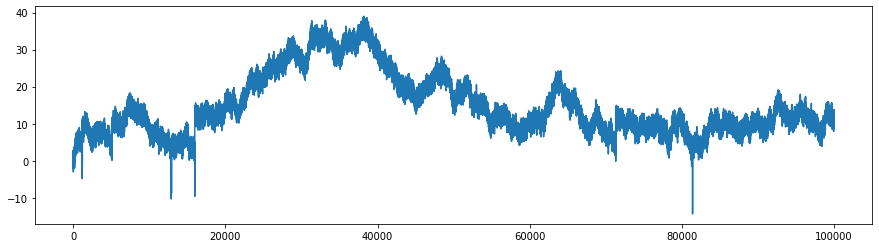

In [37]:
plt.figure(figsize=(15,4))
plt.plot(rewards)
np.mean(rewards)

In [8]:
env.r_dist

[[-0.430901303585031, 1],
 [-0.11330640938196179, 1],
 [-1.269062111734793, 1],
 [-1.2339012699491192, 1],
 [0.3643772772276374, 1],
 [1.8444563385165627, 1],
 [-1.9027183284026064, 1],
 [-0.9302978606409116, 1],
 [1.2978355792724945, 1],
 [1.4392374543820976, 1]]

In [9]:
agent.valuePredictions

array([-0.44568237, -0.27078929, -1.36165021, -1.16888231, -0.16744901,
        1.95542588, -1.88659522, -0.81701479,  1.27177149,  1.0777676 ])

In [10]:
2.0004571277448653 * 0.9

1.8004114149703787

*Exercise 2.5 (programming)* Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q\*(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the q\*(a) on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, alpha = 0.1. Use
epsilon = 0.1 and longer runs, say of 10,000 steps.

In [11]:
env2 = gym.make("BanditTenArmedNonstationaryConstantGaussian-v0")
env2.r_dist = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
game_length = 100_000
agent = BanditAgentRollingPredictions(0.1, step_size=0.1)

rewards = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    _, reward, _, _ = env2.step(action)
    agent.train(action, reward)
    rewards.append(reward)

14.77609065085238

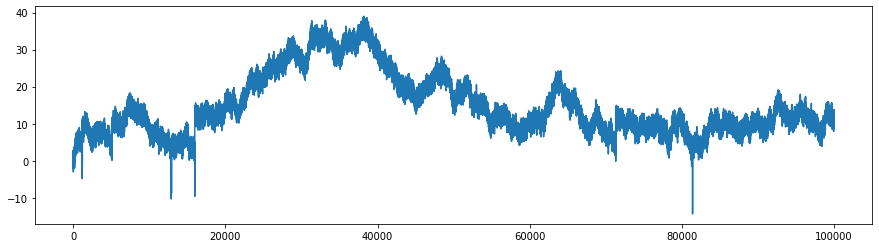

In [36]:
plt.figure(figsize=(15,4))
plt.plot(rewards)
np.mean(rewards)

In [13]:
class UnbiasedConstantStepSizeBandit():
    def __init__(self, epsilon, step_size_alpha=None):
        
        self.step_size = step_size_alpha
        self.epsilon = epsilon
        
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        
        self.valuePredictions = np.array([
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.
        ])
        
        self.currentO = 0
        
        
    def greedy_policy(self):
        action = np.argmax(self.valuePredictions)
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.actionCounts[action_taken] += 1
        self.currentO = self.currentO + self.step_size * (1 - self.currentO)
        
        error = (reward - self.valuePredictions[action_taken])
        
        lr = self.currentO
        
        new_Q = self.valuePredictions[action_taken] + lr * error
        
        self.valuePredictions[action_taken] = new_Q
        

In [14]:
env3 = gym.make("BanditTenArmedNonstationaryConstantGaussian-v0", step_size=0.1)
# env3.r_dist = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
game_length = 100_000
agent = UnbiasedConstantStepSizeBandit(0.1, step_size_alpha=0.1)

rewards = []
average_qs = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    average_qs.append(np.sum([arm[0] for arm in env3.r_dist])/10)

    _, reward, _, _ = env3.step(action)
    agent.train(action, reward)
    rewards.append(reward)

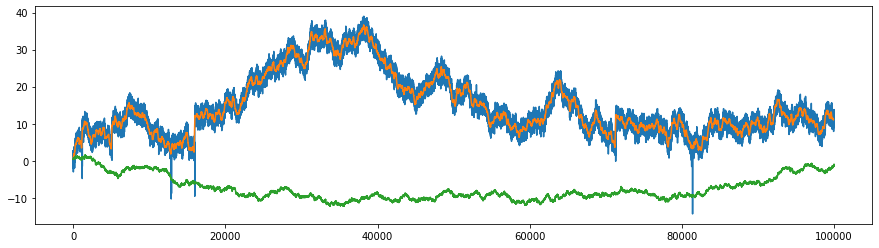

In [35]:
plt.figure(figsize=(15,4))

plt.plot(rewards)
moving_avgs = moving_average(rewards, n=100)


plt.plot(moving_avgs)
plt.plot(average_qs)

np.mean(rewards)

plt.show()

In [22]:
class UCBAgent():
    def __init__(self, exploration_factor, step_size_alpha=None):
        
        self.step_size = step_size_alpha
        self.exploration_factor = exploration_factor
        
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        
        self.valuePredictions = np.array([
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.
        ])
        
        self.currentO = 0
        
    def ucb_policy(self):
        confidence = np.array([
            20., 
            20., 
            20., 
            20., 
            20., 
            20., 
            20., 
            20., 
            20., 
            20.
        ])
        for i, Q in  enumerate(self.valuePredictions):
            if self.actionCounts[i] == 0:
                continue
            else:
                confidence[i] = Q + self.exploration_factor * (math.log(np.sum(self.actionCounts)) / self.actionCounts[i])
            
        return np.argmax(confidence)
        
    
    def train(self, action_taken, reward):
        self.actionCounts[action_taken] += 1
        self.currentO = self.currentO + self.step_size * (1 - self.currentO)
        
        error = (reward - self.valuePredictions[action_taken])
        
        lr = self.currentO
        
        new_Q = self.valuePredictions[action_taken] + lr * error
        
        self.valuePredictions[action_taken] = new_Q
        

In [46]:
env4 = gym.make("BanditTenArmedNonstationaryConstantGaussian-v0", step_size=0.1)
# env3.r_dist = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
game_length = 400_000
ucb = UCBAgent(1, step_size_alpha=0.1)

rewards = []
average_qs = []

for i in range(game_length):
    action = ucb.ucb_policy()
    average_qs.append(np.sum([arm[0] for arm in env4.r_dist])/10)

    _, reward, _, _ = env4.step(action)
    ucb.train(action, reward)
    rewards.append(reward)

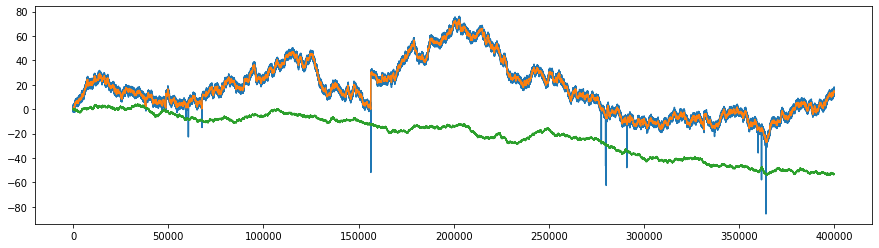

In [47]:
plt.figure(figsize=(15,4))
plt.plot(rewards)
moving_avgs = moving_average(rewards, n=100)


plt.plot(moving_avgs)
plt.plot(average_qs)

np.mean(rewards)
plt.show()

Gradient bandit algorithms

In [34]:
class GradientBandit():
    def __init__(self, step_size):
        
        self.step_size = step_size
        
        self.actionPreferences = np.zeros(shape=(10))
        self.average_reward = 0
        self.reward_sum = 0
        self.step_count = 0
        self.k = 10
        
    def pi(self, action):
        numerator = math.exp(self.actionPreferences[action])
        
        denominatorItems = []
        
        for i in range(self.k):
            denominatorItems.append(math.exp(self.actionPreferences[i]))
        denominator = np.sum( denominatorItems )
        return numerator / denominator
    
    def policy(self):
        probabilities = list( map(self.pi, range(self.k)) )
        return np.random.choice(range(self.k), p=probabilities)
        
    
    def train(self, action_taken, reward):
        
        for action in range(self.k):
            if action != action_taken:
                self.actionPreferences[action] = self.actionPreferences[action] \
                    - self.step_size * (reward - self.average_reward) * self.pi(action)
            else:
                self.actionPreferences[action_taken] = self.actionPreferences[action_taken] + \
                    self.step_size * (reward - self.average_reward) * (1 - self.pi(action_taken))
                
        self.reward_sum += reward
        self.step_count += 1
        self.average_reward = self.reward_sum / self.step_count

In [46]:
env5 = gym.make("BanditTenArmedNonstationaryConstantGaussian-v0", step_size=0.01)
# env3.r_dist = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
game_length = 300_000
gradband = GradientBandit(0.1)

rewards = []
average_qs = []

for i in range(game_length):
    action = gradband.policy()
    average_qs.append(np.sum([arm[0] for arm in env5.r_dist])/10)

    _, reward, _, _ = env5.step(action)
    gradband.train(action, reward)
    rewards.append(reward)

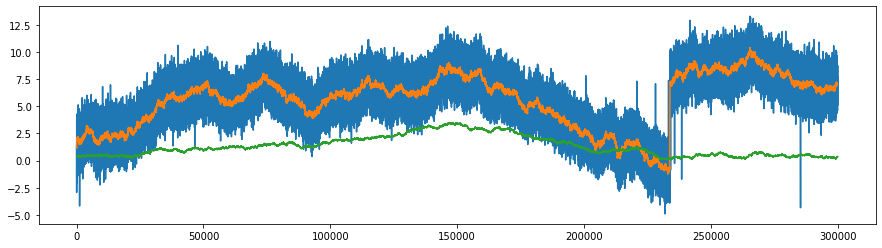

In [47]:
plt.figure(figsize=(15,4))
plt.plot(rewards)
moving_avgs = moving_average(rewards, n=100)


plt.plot(moving_avgs)
plt.plot(average_qs)

np.mean(rewards)
plt.show()